# Implementing DCA in pytorch

Source CC function in [seqmodel](https://github.com/sokrypton/seqmodels/blob/master/seqmodels.ipynb)
Reimplemeting tensorflow code in pytorch. We will try to stick with the same variables as seqmodels.

In [1]:
import numpy as np
import torch

import read_config
from dataloader import MSADataset, OneHotTransform

In [2]:
config = read_config.Config("../config_dca.yaml")
dataset = MSADataset(config.aligned_msa_fullpath, transform=OneHotTransform(21, flatten=False))

N = len(dataset)

protein_seq, weight = dataset[0]
ncat = 21
L = protein_seq.shape[0]
ncol = L

N, L

(14441, 559)

In [3]:
protein_seq.shape

torch.Size([559, 21])

In [4]:
ncol, ncat

(559, 21)

In [5]:
# L2 regularization
lam_w = 0.1
lam_b = 0.1

In [6]:
batch_size = config.batch_size
if batch_size <= 0:
    batch_size = N # entire dataset in one batch
msa = torch.utils.data.DataLoader(dataset, batch_size)

for _, msa_data in enumerate(msa):
    msa  = msa_data[0]
    msa_weights = msa_data[1]
    break
    
print(f"Data.shape = {msa.shape}")
print(f"Weights.shape = {msa_weights.shape}")

Data.shape = torch.Size([14441, 559, 21])
Weights.shape = torch.Size([14441])


In [7]:
device = config.device

In [8]:
msa = msa.to(device)
msa_weights = msa_weights.to(device)

with torch.no_grad():
    # Integer representation of protein (instead of one-hot)
    # Here each protein is represented as a number from 0 - 20
    # We need this for crossentropy
    msa_cat = msa.argmax(dim=2) # type LongTensor

    # Number of effective sequences
    Neff = torch.sum(msa_weights) 
    
    # start bias with b_ini instead of zeros
    pseudo_count = 0.01 * torch.log(Neff)
    b_ini = torch.log(torch.sum(msa.T * msa_weights, axis=-1).T + pseudo_count)
    b_ini = b_ini - torch.mean(b_ini, -1, keepdim=True)

In [9]:
bias = b_ini
bias.to(device)
bias.requires_grad = True

w = torch.zeros((ncol, ncat, ncol, ncat), dtype=torch.float, requires_grad=True, device=device)

num_epochs = config.epochs
#num_epochs = 10

# Tell the optimizer which weights we want to update
optimizer = torch.optim.Adam([bias, w], lr=config.learning_rate)
ce_loss_func = torch.nn.CrossEntropyLoss(reduction='none')

In [10]:
losses = []
for epoch in range(num_epochs):
    
    # we do not want weights between the various nodes in a given position. 
    # i.e. weights between nodes (i, a) and (j, b) only exist if i not = j
    # so set these weights to zero
    w_eye = w * torch.reshape(1 - torch.eye(ncol), (ncol,1,ncol, 1))
    # symmetrize w so that the weight between (i,a) and (j, b) is the
    # same as the weight between (j, b) and (i, a)
    weights = w_eye + w_eye.permute(2,3,0,1)
    
    msa_logit = torch.tensordot(msa, weights, 2) + bias

    # pytorch cross entropy is different from tensorflow categorical cross entropy
    # 1. It takes in the logits by default and does its own softmax activation
    # 2. It wants the class lables in the target (LongTensor instead of Float)
    #    So we use argmax to figure out where the 1 is in the one-hot vector
    loss_ce = ce_loss_func(msa_logit.permute(0,2,1), msa_cat)
    loss_ce = loss_ce.sum(dim=-1)
    loss_ce = (loss_ce * msa_weights).sum()

    reg_w = lam_w * torch.sum(torch.mul(weights, weights)) * 0.5 * (ncol-1) * 20.0 
    reg_b = lam_b * torch.sum(torch.mul(bias, bias))
    reg = reg_w + reg_b
    
    loss = (loss_ce + reg) / Neff
    losses.append(loss.item())
    print(f"Epoch={epoch:02d}, Loss={losses[-1]:6.2f}")
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()



Epoch=00, Loss=951.67
Epoch=01, Loss=806.29
Epoch=02, Loss=723.92
Epoch=03, Loss=684.01
Epoch=04, Loss=663.68
Epoch=05, Loss=649.47
Epoch=06, Loss=638.50
Epoch=07, Loss=630.74
Epoch=08, Loss=625.34
Epoch=09, Loss=620.23
Epoch=10, Loss=614.31
Epoch=11, Loss=608.15
Epoch=12, Loss=602.58
Epoch=13, Loss=598.07
Epoch=14, Loss=594.30
Epoch=15, Loss=590.55
Epoch=16, Loss=586.85
Epoch=17, Loss=583.35
Epoch=18, Loss=580.42
Epoch=19, Loss=578.00
Epoch=20, Loss=575.90
Epoch=21, Loss=573.83
Epoch=22, Loss=571.75
Epoch=23, Loss=569.80
Epoch=24, Loss=568.21
Epoch=25, Loss=566.79
Epoch=26, Loss=565.55
Epoch=27, Loss=564.29
Epoch=28, Loss=563.04
Epoch=29, Loss=561.91
Epoch=30, Loss=560.94
Epoch=31, Loss=560.05
Epoch=32, Loss=559.22
Epoch=33, Loss=558.38
Epoch=34, Loss=557.61
Epoch=35, Loss=556.94
Epoch=36, Loss=556.31
Epoch=37, Loss=555.72
Epoch=38, Loss=555.16
Epoch=39, Loss=554.61
Epoch=40, Loss=554.11
Epoch=41, Loss=553.64
Epoch=42, Loss=553.19
Epoch=43, Loss=552.78
Epoch=44, Loss=552.39
Epoch=45, 

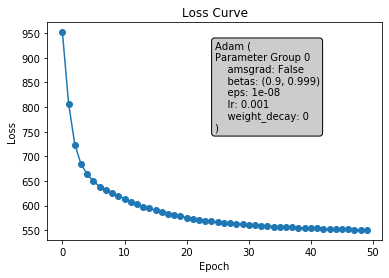

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses, "o-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(str(optimizer), (0.5, 0.5), xycoords='axes fraction',
            bbox=bbox);